# Contents
- [Counter](#Counter)
- [Andor](#Andor)
- [Hamamatsu](#Hamamatsu)
- [Count_Plots](#Count_Plots)
- [Cuts](#Cuts)
- [Loading](#Loading)
- [Retention](#Retention)
- [GOOD logger](#GOOD_Data)
- [TODO](#TODO)
- [Appendix](#Appendix)
- [Settings](#Settings)
- [Copy](#Copy)

In [1]:
%matplotlib notebook

import h5py
import matplotlib.pyplot as plt
from numpy import *
import pandas as pd
import os
import sys
from scipy.optimize import curve_fit
from scipy.special import erfc
from typing import Dict, Any
import recordclass.recordclass as rc
from itertools import product
if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"
sys.path.append(repo_path)
from datetime import datetime
import time
from configparser import ConfigParser
import logging
# local imports
import HamamatsuH5
import AndorH5
import counterh5
from Iterations import Iterations,seed_permute
from PlottingH5 import default_plotting, iterate_plot_2D, expand_iter_array
from FittingH5 import *

In [2]:
def plt_subplots(nrows=1, ncols=1,*args,**kwargs):
    """
    Function to wrap plt.subplots and make sure the same block of code can plot many axes and a single axis
    """
    fig,axarr = plt.subplots(nrows,ncols,*args,**kwargs)
    if nrows == 1 and ncols == 1:
        axarr = [axarr]
    return fig,axarr
    
h5file = h5py.File('results.hdf5',mode='r+')

iterations = Iterations(h5file)
#Find number of measurements per experiment
measurements = h5file['settings/experiment/measurementsPerIteration'][()]+1
num_its = len(h5file['iterations'])

iterations
#Find independent variable names and values
#indep_vars = DataH5.get_indep_vars(h5file)
#iVars = list(indep_vars.keys())

# map iterations to independent variable values

# iterations = DataH5.make_iterations_df(h5file, iVars)

   iteration  CONEXHoriz
0          0       4.691
1          1       4.692
2          2       4.693
3          3       4.694
4          4       4.695
5          5       4.696
6          6       4.697
7          7       4.698
8          8       4.699
9          9       4.700
10        10       4.701
11        11       4.702
12        12       4.703
13        13       4.704
14        14       4.705
15        15       4.706
16        16       4.707
17        17       4.708
18        18       4.709
19        19       4.710
20        20       4.711

# Counter

In [ ]:
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])  # Standard
shots_per_measurement = 1  # Single RO
counter_bin, counter_shot = counterh5.load_data(h5file, drop_bins, ro_bins, shots=shots_per_measurement)
count_data = counter_shot

## Plot data bins as bar graphs

In [ ]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} bin bar graphs. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        # bin shot 0 and shot 1 the same way
        for shot in range(shots_per_measurement):
            axarr[iteration].bar(range(ro_bins),counter_bin.mean(1)[iteration,shot,drop_bins:],alpha=0.5,label = f"shot {shot}")
        axarr[iteration].set_ylabel("Average counts in bin")
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
    fig.tight_layout()
    fig.show()

In [ ]:
func = lambda x,a,T,o : exp_decay(x,a,T)+o
guess = [
    25.0,
    12.0,
    5
]
args = ["Amplitude", "Decay Time (RO_bins)", "Offset"]
title = "\nDecay Time {2} = {0[1]:.2f} $\pm$ {1[1]:.2f} bins"

popts = zeros((len(guess),len(iterations),shots_per_measurement),dtype=float)
perrs = zeros(popts.shape,dtype=float)


fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for iteration, row in iterations.iterrows():
    iteration = int(iteration)
    # bin shot 0 and shot 1 the same way
    tit = str(row)
    for shot in range(shots_per_measurement):
        xdat = arange(0,ro_bins,1)
        ydat = counter_bin.mean(1)[iteration,shot,drop_bins:]
        yerr = counter_bin.std(1)[iteration,shot,drop_bins:]
        popt, pcov = curve_fit(func,xdata=xdat,ydata=ydat,sigma=yerr,p0=guess)
        perr = sqrt(diag(pcov))
        
        popts[:, iteration, shot] = popt
        perrs[:, iteration, shot] = perr
        
        xlin = linspace(min(xdat),max(xdat),1000)
        axarr[iteration].errorbar(xdat, ydat, yerr=yerr, fmt=".", label = f"data shot {shot}")
        axarr[iteration].plot(xlin, func(xlin,*popt), label = f"fit shot {shot}")
        
        tit += title.format(popt, perr, shot)
    axarr[iteration].set_ylabel("Average counts in bin")
    axarr[iteration].legend()
    axarr[iteration].set_title(tit)
fig.tight_layout()
fig.show()

for i, arg in enumerate(args):
    default_plotting(iterations, popts[i,...], perrs[i,...], shots = shots_per_measurement, description= arg, fmt = ".")

To analyze count data go to:
- [Count_Plots](#Count_Plots)

# Andor

In [ ]:
width, height = h5file['/settings/experiment/Andors/motors/motor0/camera/subimage_size'][()]
roi = HamamatsuH5.HMROI(width,height,dic = {
    "left" : 65,
    "right" : 85,
    "top" : 40,
    "bottom" : 52}
    )

andor_pix = AndorH5.load_data(h5file,roi)

andor_counts = andor_pix.sum(3).sum(3)
count_data = andor_counts
shots_per_measurement = 1

In [ ]:
#Plot number of pixels which are above a cutoff
cutoff = 5.2e3
cut_pix = andor_pix > cutoff
pass_frac = cut_pix.sum(3).sum(3)/(andor_pix.shape[-1]*andor_pix.shape[-2])
count_data = pass_frac
default_plotting(iterations,pass_frac.mean(1),pass_frac.std(1),shots_per_measurement,description="Average Fraction of pixels above a cuttoff",figsize = (8,7))

In [ ]:
rabi = False

'''# Lorenzian Lineshapes
func =  lambda x, x0, fwhm, a, o: lorenz(x, x0, fwhm, a, o)
guess = [
    24,
    2.8,
    -4,
    0.7
]
title = "MOT Depletion Spectroscopy\nx0 = {0[0]:.4e} $\pm$ {1[0]:.4e}(MHz)\nFWHM = {0[1]:.2e} $\pm$ {1[1]:.2e}(MHz)"
unit = "MHz"'''

# Double Lorenzian
func =  lambda x, x01, x02, fwhm, a, o: lorenz(x, x01, fwhm, a, 0) + lorenz(x, x02, fwhm, a, 0) + o
guess = [
    24,
    26,
    2.8,
    -4,
    0.7
]
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.4e} $\pm$ {1[0]:.4e}(MHz)\nx02 = {0[1]:.4e} $\pm$ {1[1]:.4e}(MHz)"
unit = "MHz"


'''
# Rapidly Decaying Rabi Oscillations
func = lambda t, freq, amp, offset, tau : 1/2*(amp*cos(2*pi*freq*t)*exp(-t/tau)+1)+offset
guess = [
    0.5,
    0.4,
    0.3,
    1.0
]
title = "Decaying Oscillation\n$\Omega$ = 2$\pi$x{0[0]:.2e} $\pm$ {1[0]:.2e}MHz\nT = {0[3]:.2e} $\pm$ {1[3]:.2e}uS"
unit = "uS"
rabi = True
'''

'''# Rabi Oscillations
func = lambda x, freq, amp, off: rabi_cos(x, 2*pi*freq, amp, off, phi = pi)
guess = [
    16.0,
    0.6,
    0.05
]
title = "Microwave Rabi Oscillation\n$\Omega = 2\pi x {0[0]:.1f}KHz \pm 2\pi x {0[0]:.1f}KHz$"
unit = "ms"
rabi = True'''


'''# 1-exp(-t/T)
func = o_m_exp_decay
guess = [
    0.7,
    1
]
title = "T = {0[1]:.2e}ms $\pm$ {1[1]:.2e}ms"
unit = "ms"'''

'''
# a*exp(-t/T)
func = lambda x, a, T, o: exp_decay(x,a,T)+o
guess = [
    0.8,
    3,
    0.1
]
title = "T = {0[1]:.1f}ms $\pm$ {1[1]:.1f}ms"
unit= "ms"
'''
'''
#gauss
func = gaussian
guess = [
    0.1,
    1,
    0.5
]
title = "Gauss\n mu = {0[0]:.3f} $\pm$ {1[0]:.3f}"
unit = "V"
'''

xdat = iterations[iterations.ivars[0]]
ydat = pass_frac.mean(1)[:,0]
ystd = pass_frac.std(1)[:,0]

popt, pcov = curve_fit(func, xdat, ydat, sigma=None, p0 = guess)
perr = sqrt(diag(pcov))

#unit = "us"
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(xdat,ydat,ystd,fmt=".")
xlin = linspace(min(xdat),max(xdat),1000)
ax.plot(xlin, func(xlin,*popt))
# ax.plot(xlin, func(xlin,*guess))
if rabi:
    title += f"\n$t_\pi/2 = {1/(2*popt[0]):.4f}ms$"
ax.set_title(title.format(popt,perr))
#ax.set_title(f"T = {popt[1]:.3f}ms $\pm$ {perr[1]:.3f}ms")
#ax.set_title(f"Microwave Rabi Oscillation\n$\Omega = 2\pi x {popt[0]/(2*pi):.1f}KHz \pm 2\pi x {perr[0]/(2*pi):.1f}KHz$\n$t_\pi/2 = {pi/popt[0]:.4f}ms$")
ax.set_ylabel("Retention")
ax.set_xlabel(f"{iterations.ivars[0]}({unit})")
# fig.savefig("DecreasedTrapLifetime20210209.png")
fig.show()

In [ ]:
print(popt)

## Plot 2D scan iteratively

In [ ]:
fig, axarr = iterate_plot_2D(
    iterations,
    pass_frac.mean(1)[:,0],
    pass_frac.std(1)[:,0],
    iterations.ivars[0],
    "Average Fraction of pixels above a cuttoff",
    1
)

## Fit the plot 2D scan iteratively

In [ ]:
'''
# Gaussian Functions
func = lambda x, x0, std, a : gaussian(x,x0,std,a) + 0.8
guess = [
    7.1,
    0.02,
    -0.5
]
arg_names = ["Mean (mm)", "STD (mm)", "Amplitude"]
title = "Gaussian Dip x0 = {0[0]:.3f} $\pm$ {1[0]:.3f}"
'''
'''
# Lorenzian Lineshapes
func =  lambda x, x0, fwhm, a: lorenz(x, x0, fwhm, a, 0.8)
guess = [
    18,
    2.8,
    -4
]
arg_names = ["Mean (MHz)", "FWHM (MHz)", "Amplitude"]
title = "Rydberg MOT depletion Spectroscopy\nx0 = {0[0]:.4f} $\pm$ {1[0]:.4f}(MHz)\nFWHM = {0[1]:.2e} $\pm$ {1[1]:.2e}(MHz)"

'''
# Double Lorenzian
func =  lambda x, x01, x02, fwhm, a: lorenz(x, x01, fwhm, a, 0) + lorenz(x, x02, fwhm, a, 0) + 0.6
guess = [
    20,
    28,
    2.8,
    -4,
]
arg_names = ["Mean 1 (MHz)", "Mean 2 (MHz)", "FWHM (MHz)", "Amplitude"]
title = "MOT Depletion Spectroscopy\nx01 = {0[0]:.4e} $\pm$ {1[0]:.4e}(MHz)\nx02 = {0[1]:.4e} $\pm$ {1[1]:.4e}(MHz)"
unit = "MHz"

'''
func = o_m_exp_decay
guess = [
    0.7,
    1
]
title = "T = {0[1]:.2e}ms $\pm$ {1[1]:.2e}ms"
'''

'''
# Rabi Oscillations
func = lambda x, freq, amp, off: rabi_cos(x, freq, amp, off, phi = pi/2)
guess = [
    pi*30,
    0.5,
    0.05
]
title = "$\Omega = 2pi x {0[0]:.1f}KHz \pm {1[0]:.1f}KHz$"
arg_names = ["Omega", "Amplitude", "Offset"]
'''

'''#exponential decay
func = lambda x, tau, a: a*exp(-x/tau)+0.2
guess= [
    3,
    0.5
]
title = "OP depump a*exp(-t/T)+o\nT = {0[0]:.2f}ms $\pm$ {1[0]:.2f}ms"
arg_names = ["Tau(ms)","Amplitude"]'''

x_ivar = iterations.ivars[0]
y_ivar = iterations.ivars[1]
shots = 1

popts, perrs = iterate_fit_2D(
    iterations,
    pass_frac.mean(1)[:,0],
    func,
    guess,
    data_error = pass_frac.std(1)[:,0],
    x_ivar = x_ivar,
    shots = shots
)

fig, axarr = iterate_plot_2D(
    iterations,
    pass_frac.mean(1)[:,0],
    pass_frac.std(1)[:,0],
    x_ivar,
    "Average Fraction of pixels above a cuttoff",
    shots,
    fmt="."
)

xlin = linspace(min(iterations[x_ivar]),max(iterations[x_ivar]),1000)
for i, ax in enumerate(axarr):
    for shot in range(shots):
        ax.plot(xlin,func(xlin,*popts[i,shot]))
    ax.set_title(f"{y_ivar} = {iterations.independent_variables[y_ivar][i]}\n" + title.format(popts[i,0],perrs[i,0]))
fig.tight_layout()
fig.show()


# Plot some results of the above
for i,arg in enumerate(arg_names):
    fig,ax = plt.subplots(1,1)
    y_vals = [fit_val if perrs[j,0,i] < 5*median(perrs[:,0,i]) else float("NaN") for j, fit_val in enumerate(popts[:,0,i])]
    y_error = [p_error if perrs[j,0,i] < 5*median(perrs[:,0,i]) else float("NaN") for j, p_error in enumerate(perrs[:,0,i])]
    ax.errorbar(iterations.independent_variables[y_ivar], y_vals, yerr = y_error)
    ax.set_xlabel(y_ivar)
    ax.set_ylabel(arg)
    fig.show()

In [ ]:
func = lambda x, x0, y0, a: a*(x-x0)**2+y0
guess = [
    0.5,
    38.5,
    3.0
]
title = "Quadratic Fit\nx0 = {0[0]:.3f} $\pm$ {1[0]:.3f}$V$\n"+r"-4*$\alpha_0$ =  {0[2]:.3f} $\pm$ {1[2]:.3f}$MHz/V^2$"
unit = "V"

i=0
y_vals = [fit_val for j, fit_val in enumerate(popts[:,0,i]) if perrs[j,0,i] < 5*median(perrs[:,0,i])]
y_error = [p_error for j, p_error in enumerate(perrs[:,0,i]) if perrs[j,0,i] < 5*median(perrs[:,0,i])]
x_vals = [ival for j, ival in enumerate(iterations.independent_variables[y_ivar]) if perrs[j,0,i] < 5*median(perrs[:,0,i])]

popt, pcov = curve_fit(func, x_vals, y_vals, sigma=y_error, p0=guess)
perr = sqrt(diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(x_vals,y_vals,yerr = y_error,fmt='.')
xlin = linspace(min(x_vals),max(x_vals),1000)
ax.plot(xlin,func(xlin,*popt))
ax.set_title(title.format(popt,perr))
ax.set_xlabel("1195nm Resonant Frequency")
ax.set_xlabel(f"{y_ivar}({unit})")
ax.set_ylabel("1190nm Resonant Frequency (MHz)")
fig.tight_layout()
fig.show()

In [ ]:
print(popt,perr)

## Show images

In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = row['iteration']
    axarr[iteration].imshow(andor_pix[iteration,:,im_shot,:,:].mean(0),vmin=0,vmax=cutoff+500)
    axarr[iteration].set_title(str(row))
fig.tight_layout()
fig.show()

In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = row['iteration']
    axarr[iteration].imshow(andor_pix[iteration,2,im_shot,:,:])
    axarr[iteration].set_title(str(row))
fig.tight_layout()
fig.show()

To analyze count data go to:
- [Count_Plots](#Count_Plots)

# Hamamatsu

In [ ]:
# Set ROI
fg = HamamatsuH5.set_frame_grabber_region(h5file)
width = fg['right']-fg['left']
height = fg['bottom']-fg['top']

# For documentation try > help(HMROI)
roi = HamamatsuH5.HMROI(width,height,dic = {
    "left" : 1,
    "right" : 4,
    "top" : 4,
    "bottom" : 7
})
#roi = HamamatsuH5.HMROI(width,height)

#Load data into memory
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
# pixel-by-pixel data indexed : [iteration, measurement, shot, y-pixel, x-pixel]
hm_pix = HamamatsuH5.load_data(h5file,roi)

#take pixel-by-pixel data and treat it into counter data then mean data
# "count" data indexed : [iteration, measurement, shot]
hm_counts = hm_pix.sum(3).sum(3)
# mean count data indexed : [iteration, shot]
mus = hm_counts.mean(1)
# standard deviation in mean indexed : [iteration, shot]
ers = hm_counts.std(1)/sqrt(measurements)

count_data = hm_counts

## Show images taken within ROI

In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for index, row in iterations.iterrows():
    iteration = row['iteration']
    axarr[iteration].imshow(hm_pix[iteration,:,im_shot,:,:].mean(0))
    axarr[iteration].set_title(str(row))
fig.tight_layout()
fig.show()

## Plot Histogram data of each pixel for each iteration
* Very memory hungry!
* Please clear output before saving, copying or pushing if this cell was run

In [ ]:
im_width = roi.right-roi.left
im_height = roi.bottom-roi.top
for iteration, row in iterations.iterrows():
    i = row['iteration']
    fig,axarr = plt.subplots(im_height,im_width,figsize = (10,10))
    for y in range(im_height):
        for x in range(im_width):
            bns = 20
            for shot in range(shots_per_measurement):
                axarr[y,x].hist(hm_pix[i,:,shot,y,x],bins=bns,histtype='step',label = f"Shot {shot}")
            axarr[y,x].set_title(f"x = {x}, y = {y}")
            axarr[y,x].legend()
    fig.suptitle(str(row))
    fig.tight_layout()
    fig.show()

# Count_Plots
Plot count data from some instrument (could be Hamamatsu, counter or other single-photon sensitive instrument)

## Plot Histograms of count data

In [ ]:
plots= True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    n_bins = 30
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        # bin shot 0 and shot 1 the same way
        bns = linspace(count_data[iteration,:,:].min(), count_data[iteration,:,:].max(), n_bins)
        # bin shot 0 and shot 1 differently
        # bns = n_bins
        for shot in range(shots_per_measurement):
            axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=bns)
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")

## Plot mean count data
* If only 1 iteration : Prints out means for each shot and the corresponding standard deviation
* If there is 1 independent variable : Plot means for each iteration with error bars
* If there are 2 independent variables : show image of means for each iteration.

In [ ]:
default_plotting(iterations,count_data.mean(1),count_data.std(1)/sqrt(measurements),shots_per_measurement,description="Mean Counts in ROI")

## 2D as many 1D

* Often, when a 2D scan is performed it's more enlightening to plot each row (or column) of data as a line graph

In [ ]:
iterate_plot_2D(**{
    "iterations": iterations,
    "data": count_data.mean(1),
    "data_error": count_data.std(1),
    "description": "Counts in ROI",
})

# Cuts

In [ ]:
offset = 20940
EM_gain = 500
analog_gain = 1
#count_data = HamamatsuH5.hamamatsu_count_calibration(hm_counts, offset, EM_gain, analog_gain)
shot_to_fit = 0

plots = True

fit_to = "Poisson"
if fit_to == "Poisson":
    func = double_poisson
    get_cut = poisson_intercept
    get_cut_err = cut_err_poisson
    get_overlap = poisson_discrimination_error
    guess = {
        "mu1": 5,
        "mu2": 30,
        "a1": 1000,
        "a2": 4000
    }
elif fit_to == "Gauss":
    func = double_gaussian
    get_cut = gauss_cut
    get_cut_err = cut_err_gauss
    get_overlap = gauss_discrimination_error
    guess = {
        "mu1": 5,
        "mu2": 30,
        "std1": 5,
        "std2": 15,
        "a1": 20000,
        "a2": 50000
    }
else:
    raise ValueError(f"fit_to must be either 'Poisson' or 'Gauss'. Not {fit_to}")

    
cuts = zeros(len(iterations))
multi_cuts = zeros(len(iterations))
cut_errs = zeros(len(iterations))
overlaps = zeros(len(iterations))
popts = zeros((len(iterations),len(guess)))
perrs = zeros((len(iterations),len(guess)))

for i, row in iterations.iterrows():
    iteration = row['iteration']
    bns = 40
    title = "mu1 : {0[0]:.2f} $\pm$ {1[0]:.3f} | mu2 : {0[1]:.2f} $\pm$ {1[1]:.3f}"
    popt, pcov, perr, fig, ax = fit_and_plot_hist(
        func,
        count_data[iteration,:,shot_to_fit],
        bns,
        list(guess.values()),
        title,
        plots
    )
        
    
    popt = abs(popt)
    # If our mus are switched, we switch parameters by hand
    if popt[0] > popt[1]:
        pk1 = copy(popt[0::2])
        dpk1 = copy(perr[0::2])
        popt[0::2] = popt[1::2]
        perr[0::2] = perr[1::2]
        popt[1::2] = pk1
        perr[1::2] = dpk1
    
    try:
        cut = get_cut(*popt)
        if fit_to == "Gauss":
            cut = round(cut[0])
        else:
            cut = round(cut)
        cut_err = round(get_cut_err(*append(popt,perr)),1)
        ovlp = get_overlap(cut,*popt)
    except ValueError as e:
        print(e)
        cut = popt[0]
        cut_err = 0
        ovlp = 0
        intercepts = list(gauss_intercepts(*popt))
        print(f"intercepts = {intercepts[0:2]}\na, b, c = {intercepts[2:]}")
    
    popts[iteration,:] = popt
    perrs[iteration,:] = perr
    cuts[iteration] = cut
    cut_errs[iteration] = cut_err
    overlaps[iteration] = ovlp
    if fit_to == "Poisson":
        std2 = sqrt(popt[1])
    else:
        std2 = popt[3]
    multi_cuts[iteration] = round(popt[1]+std2*3.0)  # Cut off the multi-atoms at three standard deviations
    
    if plots:
        title = title.format(popt,perr) + f"\ncut = {cut:.2f} +\- {cut_err:.3f}\noverlap = {ovlp:.3f}"
        title = f"{row}\n" + title
        ax.axvline(cut,label = 'cut')
        ax.axvline(cut-cut_err)
        ax.axvline(cut+cut_err)
        ax.axvline(multi_cuts[iteration])
        ax.legend()
        ax.set_title(title)
        fig.tight_layout()
        fig.show()
    
    print(f"Overlap : {ovlp}")
    print(f"Cut : {cut} +\- {cut_err}")
    print(f"popt : {popt}\nperr : {perr}\npcov : {pcov}")
    
# cuts = HamamatsuH5.hamamatsu_inv_calibration(cuts, offset, EM_gain, analog_gain)
# cut_errs = HamamatsuH5.hamamatsu_inv_calibration(cut_errs, offset, EM_gain, analog_gain) - offset
# multi_cuts = HamamatsuH5.hamamatsu_inv_calibration(multi_cuts, offset, EM_gain, analog_gain)

default_plotting(iterations,cuts,cut_errs,1,"Optimal Cut")
default_plotting(iterations,overlaps,shots=1,description="Classification Error Rate")
default_plotting(iterations,multi_cuts,shots=1,description="Single Atom Cut to Multi Atom Cut")


In [ ]:
default_plotting(iterations,popts[:,0],perrs[:,0],1,"mu1")
default_plotting(iterations,popts[:,1],perrs[:,1],1,"mu2")

# Loading

In [ ]:
shots = 2

hists = True  # Display histograms of loading dataq
fit_cuts = True # Use cuts derived from fits? If not uses cut specified bellow
# Make sure fits have been made to use fit cuts
if fit_cuts:
    try:
        print(cuts)
    except NameError:
        fit_cuts = False
        
# Set count data variable, so this works regadless of device
cut = 14  # 0 atom - 1 atom cut
multi_cut = 40  # 1 atom - multi atom cut

if fit_cuts:
    exp_cuts = expand_iter_array(iterations,cuts,measurements,shots_per_measurement)
    exp_cut_errs = expand_iter_array(iterations,cut_errs,measurements,shots_per_measurement).mean(1)
    exp_multi_cuts = expand_iter_array(iterations,multi_cuts,measurements,shots_per_measurement)
    exp_overlaps = expand_iter_array(iterations,overlaps,measurements,shots_per_measurement).mean(1)
    
    zero_loading = (count_data < exp_cuts).sum(1)/measurements
    zero_loading_error_bar = sqrt(shot_error(zero_loading, measurements)**2+exp_overlaps**2)
    multi_loading = (count_data > exp_multi_cuts).sum(1)/measurements
    multi_loading_error_bar = shot_error(multi_loading, measurements)
    single_loading = 1-(zero_loading+multi_loading)
    single_loading_error_bar = sqrt(shot_error(single_loading, measurements)**2+exp_overlaps**2)
    multi_to_single_loading = multi_loading/single_loading
    multi_to_single_loading_error_bar = sqrt(multi_loading_error_bar**2 + single_loading_error_bar**2)
else:
    zero_loading = (count_data < cut).sum(1)/measurements
    zero_loading_error_bar = shot_error(zero_loading, measurements)
    multi_loading = (count_data > multi_cut).sum(1)/measurements
    multi_loading_error_bar = shot_error(multi_loading, measurements)
    single_loading = 1-(zero_loading+multi_loading)
    single_loading_error_bar = shot_error(single_loading, measurements)
    multi_to_single_loading = multi_loading/single_loading
    multi_to_single_loading_error_bar = sqrt(multi_loading_error_bar**2 + single_loading_error_bar**2)
    
loadings = {
    0: "Zero",
    1: "Single",
    2: "Multi",
    3: "Multi_to_Single"
}

if hists and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    hists = ans=="Y"
    
if hists:
    fig,axarr = plt_subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        for shot in range(shots_per_measurement):
            bins = 40
            bns = linspace(count_data[iteration, :, :].min(), count_data[iteration, :, :].max(),bins)
            axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=bns)
        axarr[iteration].legend()
        if fit_cuts:
            cut = cuts[iteration]
            multi_cut = multi_cuts[iteration]
            axarr[iteration].axvline(cut+cut_errs[iteration])
            axarr[iteration].axvline(cut-cut_errs[iteration])
        axarr[iteration].axvline(cut)
        axarr[iteration].axvline(multi_cut)
        axarr[iteration].set_title(str(row))
        fig.tight_layout()
    fig.show()
else:
    print("You have chosen not to plot the histograms.")
for num,name in loadings.items():
    rate = eval(f"{name.lower()}_loading")
    rate_error_bar = eval(f"{name.lower()}_loading_error_bar")
    default_plotting(iterations,rate,rate_error_bar,shots=shots,description = f"{name} atom loading")

# Retention

In [ ]:
shots = 2

fit_cuts = True
# Use cuts derived from fitting in "Cuts" cell? If False hardcoded cut bellow will be used
if fit_cuts:
    try:
        print(f"printing cuts array {cuts}")
    except NameError:
        fit_cuts = False

# Set count data variable, so this works regadless of device
cut = 16  # 0 atom - 1 atom cut
multi_cut = 200 # 1 atom - multi atom cut

if fit_cuts:
    exp_cuts = expand_iter_array(iterations,cuts,measurements,shots_per_measurement)
    exp_cut_errs = expand_iter_array(iterations,cut_errs,measurements,shots_per_measurement).mean(1)
    exp_multi_cuts = expand_iter_array(iterations,multi_cuts,measurements,shots_per_measurement)
    exp_overlaps = expand_iter_array(iterations,overlaps,measurements,shots_per_measurement).mean(1).mean(1)
    
    single_loading = (count_data < exp_multi_cuts)*(count_data > exp_cuts) # Measurements that were loaded
else:
    single_loading = (count_data < multi_cut)*(count_data > cut)  # Measurements that were loaded
    exp_overlaps = 0  # Hardcode classification error rate here

retained = single_loading[...,1]*single_loading[...,0]  # Measurements that were retained
loaded = single_loading[...,0].sum(1)  # Number of loaded measurements in each iteration
#print(retained)
#print(loaded)
loaded = [10**-6 if l==0 else l for l in loaded]
#print(loaded)

retention = retained.sum(1)/loaded
retention_error_bar = sqrt(shot_error(retention,loaded)**2+exp_overlaps**2)

default_plotting(iterations,retention,retention_error_bar,description = "Retention")

In [ ]:
fig,ax=plt.subplots(1,1)
ax.errorbar(iterations[iterations.ivars[0]][1:],retention[1:],yerr=retention_error_bar[1:])
fig.show()

## Fit 1D scan

In [ ]:
rabi = False

# Lorenzian Lineshapes
'''func =  lambda x, x0, fwhm, a, o: lorenz(x, x0, fwhm, a, o)
guess = [
    449.9,
    0.3,
    -1e-2,
    0.7
]
title = "uW Spectroscopy\nx0 = {0[0]:.4e} $\pm$ {1[0]:.4e}(MHz)\nFWHM = {0[1]:.2e} $\pm$ {1[1]:.2e}(MHz)"
unit = "MHz"
'''
'''
# Rapidly Decaying Rabi Oscillations
func = lambda t, freq, amp, offset, tau : 1/2*(amp*cos(2*pi*freq*t)*exp(-t/tau)+1)+offset
guess = [
    0.5,
    0.4,
    0.3,
    1.0
]
title = "Decaying Oscillation\n$\Omega$ = 2$\pi$x{0[0]:.2e} $\pm$ {1[0]:.2e}MHz\nT = {0[3]:.2e} $\pm$ {1[3]:.2e}uS"
unit = "uS"
rabi = True
'''

'''# Rabi Oscillations
func = lambda x, freq, amp, off: rabi_cos(x, 2*pi*freq, amp, off, phi = pi)
guess = [
    16.0,
    0.6,
    0.05
]
title = "Microwave Rabi Oscillation\n$\Omega = 2\pi x {0[0]:.1f}KHz \pm 2\pi x {0[0]:.1f}KHz$"
unit = "ms"
rabi = True'''


# 1-exp(-t/T)
func = o_m_exp_decay
guess = [
    0.7,
    1
]
title = "T = {0[1]:.2e}ms $\pm$ {1[1]:.2e}ms"
unit = "ms"

'''
# a*exp(-t/T)
func = lambda x, a, T, o: exp_decay(x,a,T)+o
guess = [
    0.8,
    3,
    0.1
]
title = "T = {0[1]:.1f}ms $\pm$ {1[1]:.1f}ms"
unit= "ms"
'''
'''
#gauss
func = gaussian
guess = [
    0.1,
    1,
    0.5
]
title = "Gauss\n mu = {0[0]:.3f} $\pm$ {1[0]:.3f}"
unit = "V"
'''

xdat = iterations[iterations.ivars[0]]
ydat = retention
ystd = retention_error_bar

popt, pcov = curve_fit(func, xdat, ydat, sigma=None, p0 = guess)
perr = sqrt(diag(pcov))

#unit = "us"
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(xdat,ydat,ystd,fmt=".")
xlin = linspace(min(xdat),max(xdat),1000)
ax.plot(xlin, func(xlin,*popt))
# ax.plot(xlin, func(xlin,*guess))
if rabi:
    title += f"\n$t_\pi/2 = {1/(2*popt[0]):.4f}ms$"
ax.set_title(title.format(popt,perr))
#ax.set_title(f"T = {popt[1]:.3f}ms $\pm$ {perr[1]:.3f}ms")
#ax.set_title(f"Microwave Rabi Oscillation\n$\Omega = 2\pi x {popt[0]/(2*pi):.1f}KHz \pm 2\pi x {perr[0]/(2*pi):.1f}KHz$\n$t_\pi/2 = {pi/popt[0]:.4f}ms$")
ax.set_ylabel("Retention")
ax.set_xlabel(f"{iterations.ivars[0]}({unit})")
# fig.savefig("DecreasedTrapLifetime20210209.png")
fig.show()

## Plot 2D scan iteratively

In [ ]:
fig, axarr = iterate_plot_2D(
    iterations,
    retention,
    retention_error_bar,
    iterations.ivars[0],
    "Retention",
    1
)

## Fit the plot 2D scan iteratively

In [ ]:
'''# Gaussian Functions
func = lambda x, x0, std, a : gaussian(x,x0,std,a) + 0.8
guess = [
    7.1,
    0.02,
    -0.5
]
arg_names = ["Mean (mm)", "STD (mm)", "Amplitude"]
title = "Gaussian Dip x0 = {0[0]:.3f} $\pm$ {1[0]:.3f}"'''
'''
# Lorenzian Lineshapes
func =  lambda x, x0, fwhm, a, o: lorenz(x, x0, fwhm, a, o)
guess = [
    0.001,
    0.012,
    1.1e-4,
    0.01
]
arg_names = ["Mean (MHz)", "FWHM (MHz)", "Amplitude", "Offset"]
title = "Microwave Spectroscopy\nx0 = {0[0]:.4f} $\pm$ {1[0]:.4f}(MHz)\nFWHM = {0[1]:.2e} $\pm$ {1[1]:.2e}(MHz)"
'''
'''
func = o_m_exp_decay
guess = [
    0.7,
    1
]
title = "T = {0[1]:.2e}ms $\pm$ {1[1]:.2e}ms"
'''

'''
# Rabi Oscillations
func = lambda x, freq, amp, off: rabi_cos(x, freq, amp, off, phi = pi/2)
guess = [
    pi*30,
    0.5,
    0.05
]
title = "$\Omega = 2pi x {0[0]:.1f}KHz \pm {1[0]:.1f}KHz$"
arg_names = ["Omega", "Amplitude", "Offset"]
'''

#exponential decay
func = lambda x, tau, a: a*exp(-x/tau)+0.2
guess= [
    3,
    0.5
]
title = "OP depump a*exp(-t/T)+o\nT = {0[0]:.2f}ms $\pm$ {1[0]:.2f}ms"
arg_names = ["Tau(ms)","Amplitude"]

x_ivar = iterations.ivars[0]
y_ivar = iterations.ivars[1]
shots = 1

popts, perrs = iterate_fit_2D(
    iterations,
    retention,
    func,
    guess,
    data_error = retention_error_bar,
    x_ivar = x_ivar,
    shots = shots
)

fig, axarr = iterate_plot_2D(
    iterations,
    retention,
    retention_error_bar,
    x_ivar,
    "Retention",
    shots,
    fmt="."
)

xlin = linspace(min(iterations[x_ivar]),max(iterations[x_ivar]),1000)
for i, ax in enumerate(axarr):
    for shot in range(shots):
        ax.plot(xlin,func(xlin,*popts[i,shot]))
    ax.set_title(f"{y_ivar} = {iterations.independent_variables[y_ivar][i]}\n" + title.format(popts[i,0]/(2*pi),perrs[i,0]/(2*pi)))
fig.tight_layout()
fig.show()


# Plot some results of the above
for i,arg in enumerate(arg_names):
    fig,ax = plt.subplots(1,1)
    ax.errorbar(iterations.independent_variables[y_ivar], popts[:,0,i], yerr = perrs[:,0,i])
    ax.set_xlabel(y_ivar)
    ax.set_ylabel(arg)
    fig.show()

In [ ]:
std_devs = popts[:,0,0]
std_errs = perrs[:,0,0]

xdata = iterations.independent_variables[y_ivar]
func = lambda x, m, b : m*x+b
guess = [0.07/0.8, 0]

popt, pcov = curve_fit(func, xdata, std_devs, sigma=std_errs,p0=guess)
perr = sqrt(diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(iterations.independent_variables[y_ivar], std_devs, yerr=std_errs, fmt=".")
xlin = linspace(min(xdata),max(xdata),1000)
ax.plot(xlin,func(xlin,*popt))
ax.set_title(f"m = {popt[0]:.3f} $\pm$ {perr[0]:.3f}mm/mm, b = {popt[1]:.3f} $\pm$ {perr[1]:.3f}mm")
#ax.set_title(f"V0 = {popt[0]:.3e} $\pm$ {perr[0]:.3e}V\nm = {popt[1]:.3e} $\pm$ {perr[1]:.3e}$MHz/V^2$")
fig.show()

In [ ]:
std_devs = popts[:,0,1]
std_errs = perrs[:,0,1]

xdata = iterations.independent_variables[y_ivar]
func = lambda z, z0, w0, zr: w0*sqrt(1+((z-z0)/zr)**2)
guess = [3.0,0.010,0.1]

popt, pcov = curve_fit(func, xdata, std_devs, sigma=std_errs,p0=guess)
perr = sqrt(diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(iterations.independent_variables[y_ivar], std_devs, yerr=std_errs)
xlin = linspace(min(xdata),max(xdata),1000)
ax.plot(xlin,func(xlin,*popt))
ax.set_title(f"z0 = {popt[0]:.3f} $\pm$ {perr[0]:.3f}, w0 = {popt[1]:.3f} $\pm$ {perr[1]:.3f}\n zr = {popt[2]:.3f} $\pm$ {perr[2]:.3f}")
#ax.set_title(f"V0 = {popt[0]:.3e} $\pm$ {perr[0]:.3e}V\nm = {popt[1]:.3e} $\pm$ {perr[1]:.3e}$MHz/V^2$")
fig.show()

In [ ]:
func = o_m_exp_decay
guess = [
    0.7,
    1
]
title = "T = {0[1]:.2e}ms $\pm$ {1[1]:.2e}ms"


popt, pcov = curve_fit(func,iterations.independent_variables[y_ivar],popts[:,0,1],sigma=perrs[:,0,1],p0=guess)
perr = sqrt(diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(iterations.independent_variables[y_ivar], popts[:,0,1], yerr = perrs[:,0,1])
xlin = linspace(min(iterations.independent_variables[y_ivar]),max(iterations.independent_variables[y_ivar]),1000)
ax.plot(xlin,func(xlin,*popt))
ax.set_title(title.format(popt,perr))
ax.set_xlabel(y_ivar)
ax.set_ylabel(f"Amplitude")
fig.show()

# GOOD_Data
Pull data from the good logger and match it with measurements taken

In [3]:
from GOODH5 import load_origin_data
stream = "Hybrid_Mux"
fields = ["PowerMeter", "FORT"]
GOOD_data = load_origin_data(h5file, iterations, measurements, stream, fields)

<IPython.core.display.Javascript object>


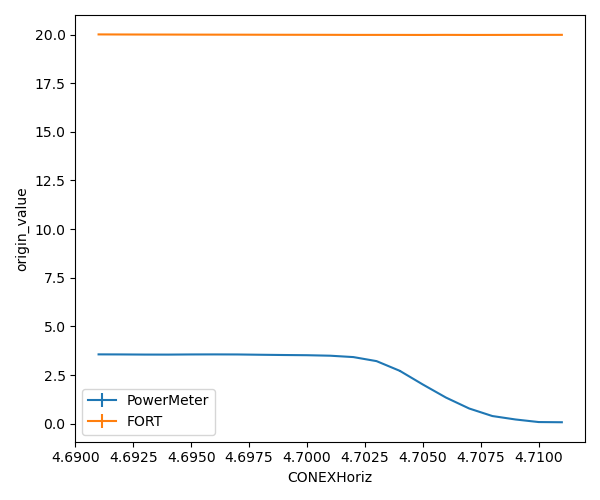

In [29]:
mean_data = array([[dataset.mean() for field, dataset in GOOD_df.items() if field != "measurement_time_dt"] for GOOD_df in GOOD_data])
std_data = array([[dataset.std()/sqrt(len(dataset)) for field, dataset in GOOD_df.items() if field != "measurement_time_dt"] for GOOD_df in GOOD_data])
default_plotting(iterations, mean_data, std_data, fields, "origin_value")

## Fit GOOD logger data to a curve

<IPython.core.display.Javascript object>


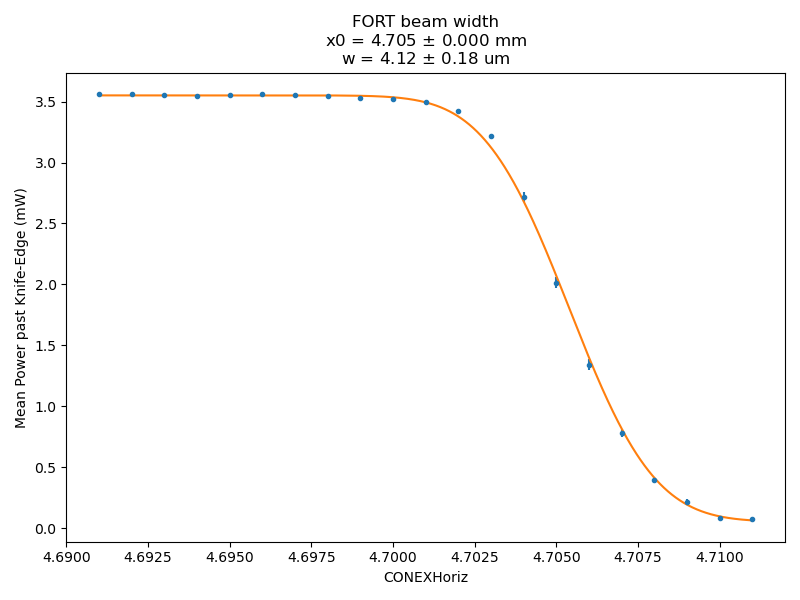

In [31]:
# 1D scan ONLY
func = lambda x, x0, w, a, o: a*erfc(sqrt(2)*(x-x0) / w ) + o
guess = [
    4.715,
    15.0e-3,
    25.5,
    2.5
]
title= "Knife Edge Width Measurement\nx0 = {0[0]:.4f}mm $\pm$ {1[0]:.5f}mm\nw = {0[1]:.5f}mm $\pm$ {1[1]:.5f}mm"
arg_names = ["Beam Center Position (mm)", "Beam Width (mm)", "Amplitude (mW)", "Offset (mW)"]

xdat = iterations.independent_variables[iterations.ivars[0]]
field = "PowerMeter"
field_ind = where(fields == fields)[0][0]
ydat = mean_data[:,field_ind]
yerr= std_data[:,field_ind]

popt, pcov = curve_fit(func, xdat, ydat, sigma = yerr, p0=guess)
perr = sqrt(diag(pcov))

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.errorbar(xdat, ydat, yerr = yerr, fmt = '.')
xlin = linspace(min(xdat), max(xdat), 1000)
ax.plot(xlin, func(xlin, *popt))
ax.set_ylabel("Mean Power past Knife-Edge (mW)")
ax.set_xlabel(iterations.ivars[0])
ax.set_title(f"FORT beam width\nx0 = {popt[0]:.3f} $\pm$ {perr[0]:.3f} mm\nw = {popt[1]*1e3:.2f} $\pm$ {perr[1]*1e3:.2f} um")
fig.tight_layout()
fig.show()

In [ ]:
fig, axarr = iterate_plot_2D(
    iterations,
    mu_data,
    std_data,
    iterations.ivars[1],
    "Mean Power past knife-edge(mW)",
    fields
)

In [ ]:
'''#exponential decay
func = lambda x, tau, a: a*exp(-x/tau)+0.2
guess= [
    3,
    0.5
]
title = "OP depump a*exp(-t/T)+o\nT = {0[0]:.2f}ms $\pm$ {1[0]:.2f}ms"
arg_names = ["Tau(ms)","Amplitude"]'''

func = lambda x, x0, w, a, o: a*erfc(sqrt(2)*(x-x0) / w ) + o
guess = [
    4.702,
    2.2e-3,
    3.5,
    0
]
title= "Knife Edge Width Measurement\nx0 = {0[0]:.4f}mm $\pm$ {1[0]:.4f}mm\nw = {0[1]:.5f}mm $\pm$ {1[1]:.5f}mm"
arg_names = ["Beam Center Position (mm)", "Beam Width (mm)", "Amplitude (mW)", "Offset (mW)"]

x_ivar = iterations.ivars[1]
y_ivar = iterations.ivars[0]
shots = 1

field = "PowerMeter"
field_ind = where(fields == fields)[0][0]
ydat = mean_data[:,field_ind]
yerr= std_data[:,field_ind]

popts, perrs = iterate_fit_2D(
    iterations,
    ydat,
    func,
    guess,
    data_error = yerr,
    x_ivar = x_ivar,
    shots = shots
)

fig, axarr = iterate_plot_2D(
    iterations,
    ydat,
    yerr,
    x_ivar,
    "Mean Power past knife-edge(mW)",
    shots,
    fmt="."
)

xlin = linspace(min(iterations[x_ivar]),max(iterations[x_ivar]),1000)
for i, ax in enumerate(axarr):
    for shot in range(shots):
        ax.plot(xlin,func(xlin,*popts[i,shot]))
    ax.set_title(f"{y_ivar} = {iterations.independent_variables[y_ivar][i]}\n" + title.format(popts[i,0],perrs[i,0]))
fig.tight_layout()
fig.show()


# Plot some results of the above
for i,arg in enumerate(arg_names):
    fig,ax = plt.subplots(1,1)
    ax.errorbar(iterations.independent_variables[y_ivar], popts[:,0,i], yerr = perrs[:,0,i])
    ax.set_xlabel(y_ivar)
    ax.set_ylabel(arg)
    fig.show()

In [ ]:
w_z = lambda x, x0, w0, zr: w0 * sqrt(1 + ((x-x0) / zr)**2 )
func = w_z
guess = [
    3.961,
    min(popts[:,0,1]),
    pi*min(popts[:,0,1])**2/938e-6
]
ydat = popts[:,0,1]
yerr = perrs[:,0,1]

xdat = iterations.independent_variables[y_ivar]

popt, pcov = curve_fit(func, xdat, ydat, sigma = yerr, p0=guess)
perr = sqrt(diag(pcov))

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.errorbar(xdat, ydat, yerr = yerr, fmt = '.')
xlin = linspace(min(xdat), max(xdat), 1000)
ax.plot(xlin, func(xlin, *popt))
# ax.plot(xlin, func(xlin, *guess))
ax.set_ylabel("Beam width (mm)")
ax.set_xlabel(y_ivar)
ax.set_title(f"Fort width wrt Focal Position\nZ0 = {popt[0]:.3f} $\pm$ {perr[0]:.3f} mm\nw0 = {popt[1]*1e3:.2f} $\pm$ {perr[1]*1e3:.2f} um\nZr = {popt[2]*1e3:.2f} $\pm$ {perr[2]*1e3:.2f} um")
fig.tight_layout()
fig.show()

# TODO
- Make array of iteration-by-iteration classification errors from Cuts cells.
    - Specifically, adding classification errors due to function overlaps and cut_uncertainty, in quadrature
- Compartmentalize parts of Cuts cells for ease of use
- Move Utility and Calibration functions to files
- Make functions inside files for general discrimination
- Load info like Cut values, Camera calibrations etc into variables or class attributes to be used throughout notebook

# Appendix
Code that was written once, perhaps incidentally, and may be useful in the future

## Optimization, Counter Data
Code bellow picked out a subset of iterations from a long optimization run, and loaded counter data from that run. It then performed some hacky versions of the above analyses on them (Loading and Retention) 

In [ ]:
its = len(h5file['iterations'])
iterations = 10
measurements = int(h5file['/settings/experiment/measurementsPerIteration'][()])
shots = 2
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
tot_bins = drop_bins+ro_bins
                   
    
n_filters = counterh5.check_n_filter(h5file)
    
bin_data = zeros((iterations,measurements,shots,tot_bins))

for iteration in range(iterations):
    for measurement in range(measurements):
        ms = measurement + n_filters
        it = its - 2 - iteration
        adr = f"/iterations/{it}/measurements/{ms}/data/counter/data"
        print(adr)
        raw_data = array(h5file[adr][()])[0]
        for shot in range(shots):
            bin_data[iteration,measurement,shot,:] = raw_data[shot*tot_bins:(shot+1)*tot_bins]
            
count_data = bin_data[...,drop_bins:].sum(3)

In [ ]:
n_bins = 30
fig,axarr = plt_subplots(iterations,1,figsize=(6,4*iterations))
for iteration in range(iterations):
    iteration = int(iteration)
    # bin shot 0 and shot 1 the same way
    bns = linspace(count_data[iteration,:,:].min(), count_data[iteration,:,:].max(), n_bins)
    # bin shot 0 and shot 1 differently
    # bns = n_bins
    for shot in range(shots):
        axarr[iteration].hist(count_data[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=bns)
    axarr[iteration].legend()
    axarr[iteration].set_title(str(its-1-iteration))
    fig.tight_layout()
fig.show()

In [ ]:
shots = 2

# Set count data variable, so this works regadless of device
cut = 70  # 0 atom - 1 atom cut
multi_cut = 195  # 1 atom - multi atom cut


single_loading = (count_data < multi_cut)*(count_data > cut)  # Measurements that were loaded
exp_overlaps = 0  # Hardcode classification error rate here

retained = single_loading[...,1]*single_loading[...,0]  # Measurements that were retained
loaded = single_loading[...,0].sum(1)  # Number of loaded measurements in each iteration
print(retained)
print(loaded)
loaded = [10**-6 if l==0 else l for l in loaded]
print(loaded)

retention = retained.sum(1)/loaded
retention_error_bar = sqrt(shot_error(retention,loaded)**2+exp_overlaps**2)

fig,ax = plt.subplots(1,1)
ax.errorbar(list(range(its-1,its-iterations-1,-1)),retention,retention_error_bar)
fig.show()


In [ ]:
# find optimized variables
opt_vars = []
for variable in h5file['settings/experiment/independentVariables'].items():
    optimizing = variable[1]['optimize'][()]
    # print(f"{variable[0]} : {variable[1]['optimize'][()]}")
    if optimizing:
        opt_vars.append(variable[0])
print(opt_vars)


its_df = pd.DataFrame(columns=['iteration'] + opt_vars)
# Load those values for our iterations into a dataframe
for iteration in range(iterations):
    it = its - 1 - iteration
    opt_vals = {'iteration': it}
    for var in opt_vars:
        adr = f"/iterations/{it}/variables/{var}"
        opt_vals.update({var:h5file[adr][()]})
    its_df = its_df.append(pd.DataFrame(opt_vals,index=[it]))
    

In [ ]:
its_df

In [ ]:
for var in its_df:
    print(f"{var}: {its_df[var].mean():.3f} +\- {its_df[var].std():.3f}")

In [ ]:
import numpy as np
def test_load_data(
        results_file: h5py.File,
        drop_bins: int,
        ro_bins: int,
        shots: int = None
) -> Tuple[ndarray, ndarray]:
    """
    Load data from a counter instrument into a numpy array

    results are indexed as follows
    > results = array[iteration, measurement, shot]
    Args:
        results_file: h5file object corresponding to the results.hdf5 file being analyzed
        drop_bins: number of bins to drop at the start of each shot
        ro_bins: number of readout bins expected in each shot
        shots: number of shots taken in the experiment. Default is 2

    Returns:
        (binned_counter_data, shot_counter_data)
            binned_counter_data : 4D numpy array holding the counter data taken by the given counter
                during the experiment. Each entry corresponds to the number of counts detected
                during a binning period
                indexed [iteration, measurement, shot, ro_bin]
            shot_counter_data : a 3D numpy array holding the counter data taken by the given counter
                during the experiment. Each entry corresponds to the number of counts detected
                during a shot. counts detected by the first drop_bins bins in a shot are discarded
                from this array
                shot_counter_data = binned_counter_data[..., drop_bins:].sum(3)
                indexed [iteration, measurement, shot]
    """
    num_its = len(results_file['iterations'])
    measurements = results_file['settings/experiment/measurementsPerIteration'][()]+1
    if shots is None:
        shots_per_measurement = int(
            results_file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
    else:
        shots_per_measurement = shots

    binned_counter_data = np.zeros(
        (num_its, measurements, shots_per_measurement, drop_bins + ro_bins),
        dtype=int
    )

    for iteration, i_group in results_file['iterations'].items():
        # print(f"iteration : {iteration} : {type(iteration)}")
        for measurement, m_group in i_group['measurements'].items():
            # load data, a 1D array of counter data from the measurement, each entry corresponds to
            # the measured counts in a given binning period
            raw_data = np.array(m_group['data/counter/data'][()])[0]
            for shot in range(shots_per_measurement):
                tot_bins = drop_bins + ro_bins
                iteration = int(iteration)
                measurement = int(measurement)
                inds = {
                    "iteration": iteration,
                    "measurement": measurement,
                    "shot": shot,
                    "tot_bins": tot_bins,
                    "raw_data.shape": raw_data.shape
                }
                ind_msg = ",".join([f"{var} : {val}" for var, val in inds.items()])
                print(ind_msg)
                try:
                    binned_counter_data[iteration, measurement, shot, :] = raw_data[shot*tot_bins: (shot + 1) * tot_bins]
                except (IndexError, ValueError) as ie:
                    inds = {
                        "iteration": iteration,
                        "measurement": measurement,
                        "shot": shot,
                        "tot_bins": tot_bins,
                        "raw_data.shape": raw_data.shape}
                    print(iteration)
                    ind_msg = ",".join([f"{var} : {val}" for var, val in inds.items()])
                    print(f"Warning. Error for {ind_msg}\n {ie}")
                    continue

    shot_counter_data = binned_counter_data[..., drop_bins:].sum(3)

    return binned_counter_data, shot_counter_data

In [ ]:
drop_bins = h5file["/iterations/0/variables/RO1_drops"][()]
ro_bins = h5file["/iterations/0/variables/RO1_bins"][()]
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
counter_bin, counter_shot = test_load_data(h5file, drop_bins, ro_bins)
count_data = counter_shot

In [ ]:
where(counter_bin == 0)

# Settings

In [ ]:
for name,group in h5file['settings/experiment/independentVariables/'].items():
    print(f"{name} : \t\t {group['function'][()]}")

# Copy

In [ ]:
# Copy to next results folder

import datetime
import shutil
import re
import os
import operator
from numpy import sort

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# find latest day folder created by cspy
daily_folders = list(filter(
    dir_filter,
    [os.path.join(measurement_path,f) for f in os.listdir(measurement_path)]
))  # make sure non-folder names are not listed
today_path = sort(daily_folders)[-1]
print(today_path)
#find all experiments taken on the last day
experiments_today = list(filter(
    dir_filter,
    [os.path.join(today_path,f) for f in os.listdir(today_path)]
))
#and the last experiment taken the last day
last_experiment = sort(experiments_today)[-1]
exp_path = os.path.join(today_path, last_experiment)

# Copy
if analysis_fname not in os.listdir(exp_path) or override:
    print("Copying {} from :\n\t{}\nto:\n\t{}".format(analysis_fname,os.getcwd(),exp_path))
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),exp_path)
else:
    print("Folder {} already have analysis file. If you wish to overwrite that file set 'override' to True".format(exp_path))

In [ ]:
# Copy to Git Repo

import datetime
import shutil
import re
import os
import operator
from numpy import sort

if (os.name == 'posix'):
    repo_path = r"/Volumes/C/Public/Users/Hybrid/Repos/Hybrid_H5/H5_python3"
else:
    repo_path = r"C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3"

volume = os.getcwd()[0]
analysis_fname = 'Analysis3.ipynb'
measurement_path = os.path.dirname(os.path.dirname(os.getcwd()))
dir_filter = lambda f : os.path.isdir(f)

# If the latest experiment folder already has an analysis file, should that be overwritten?
override = True

# Copy
if analysis_fname not in os.listdir(repo_path) or override:
    print(f"Copying {analysis_fname} from :\n\t{os.getcwd()}\nto:\n\t{repo_path}")
    shutil.copy(os.path.join(os.getcwd(),analysis_fname),repo_path)
else:
    print(f"Folder {repo_path} already have analysis file. If you wish to overwrite that file set 'override' to True")